=== Basic Statistics ===
Total dialogues attempted: 1036
Success rate: 95.95%
Total retries: 42

=== Performance Patterns ===
Number of high-latency requests (>34.88s): 33
Percentage of high-latency requests: 1.63%
Average tokens in high-latency requests: 793.5
Average tokens in normal requests: 717.6
Token usage ratio (high/normal): 1.11x

=== Token Efficiency Analysis ===
Average tokens per turn: 117.7
Median tokens per turn: 84.5
Most efficient dialogue (min tokens/turn): 23.7
Least efficient dialogue (max tokens/turn): 1165.0
Correlation between turns and token usage: -0.012

=== Retry Pattern Analysis ===
Dialogues with 0 retries: 975 (98.09%)
Dialogues with 1 retries: 14 (1.41%)
Dialogues with 2 retries: 5 (0.50%)

=== Detailed Latency Analysis ===
Latency stability (CV): 0.875
Latency standard deviation: 11.10s
50th percentile latency: 8.54s
75th percentile latency: 20.68s
90th percentile latency: 25.33s
95th percentile latency: 29.09s
99th percentile latency: 41.80s

=== Correl

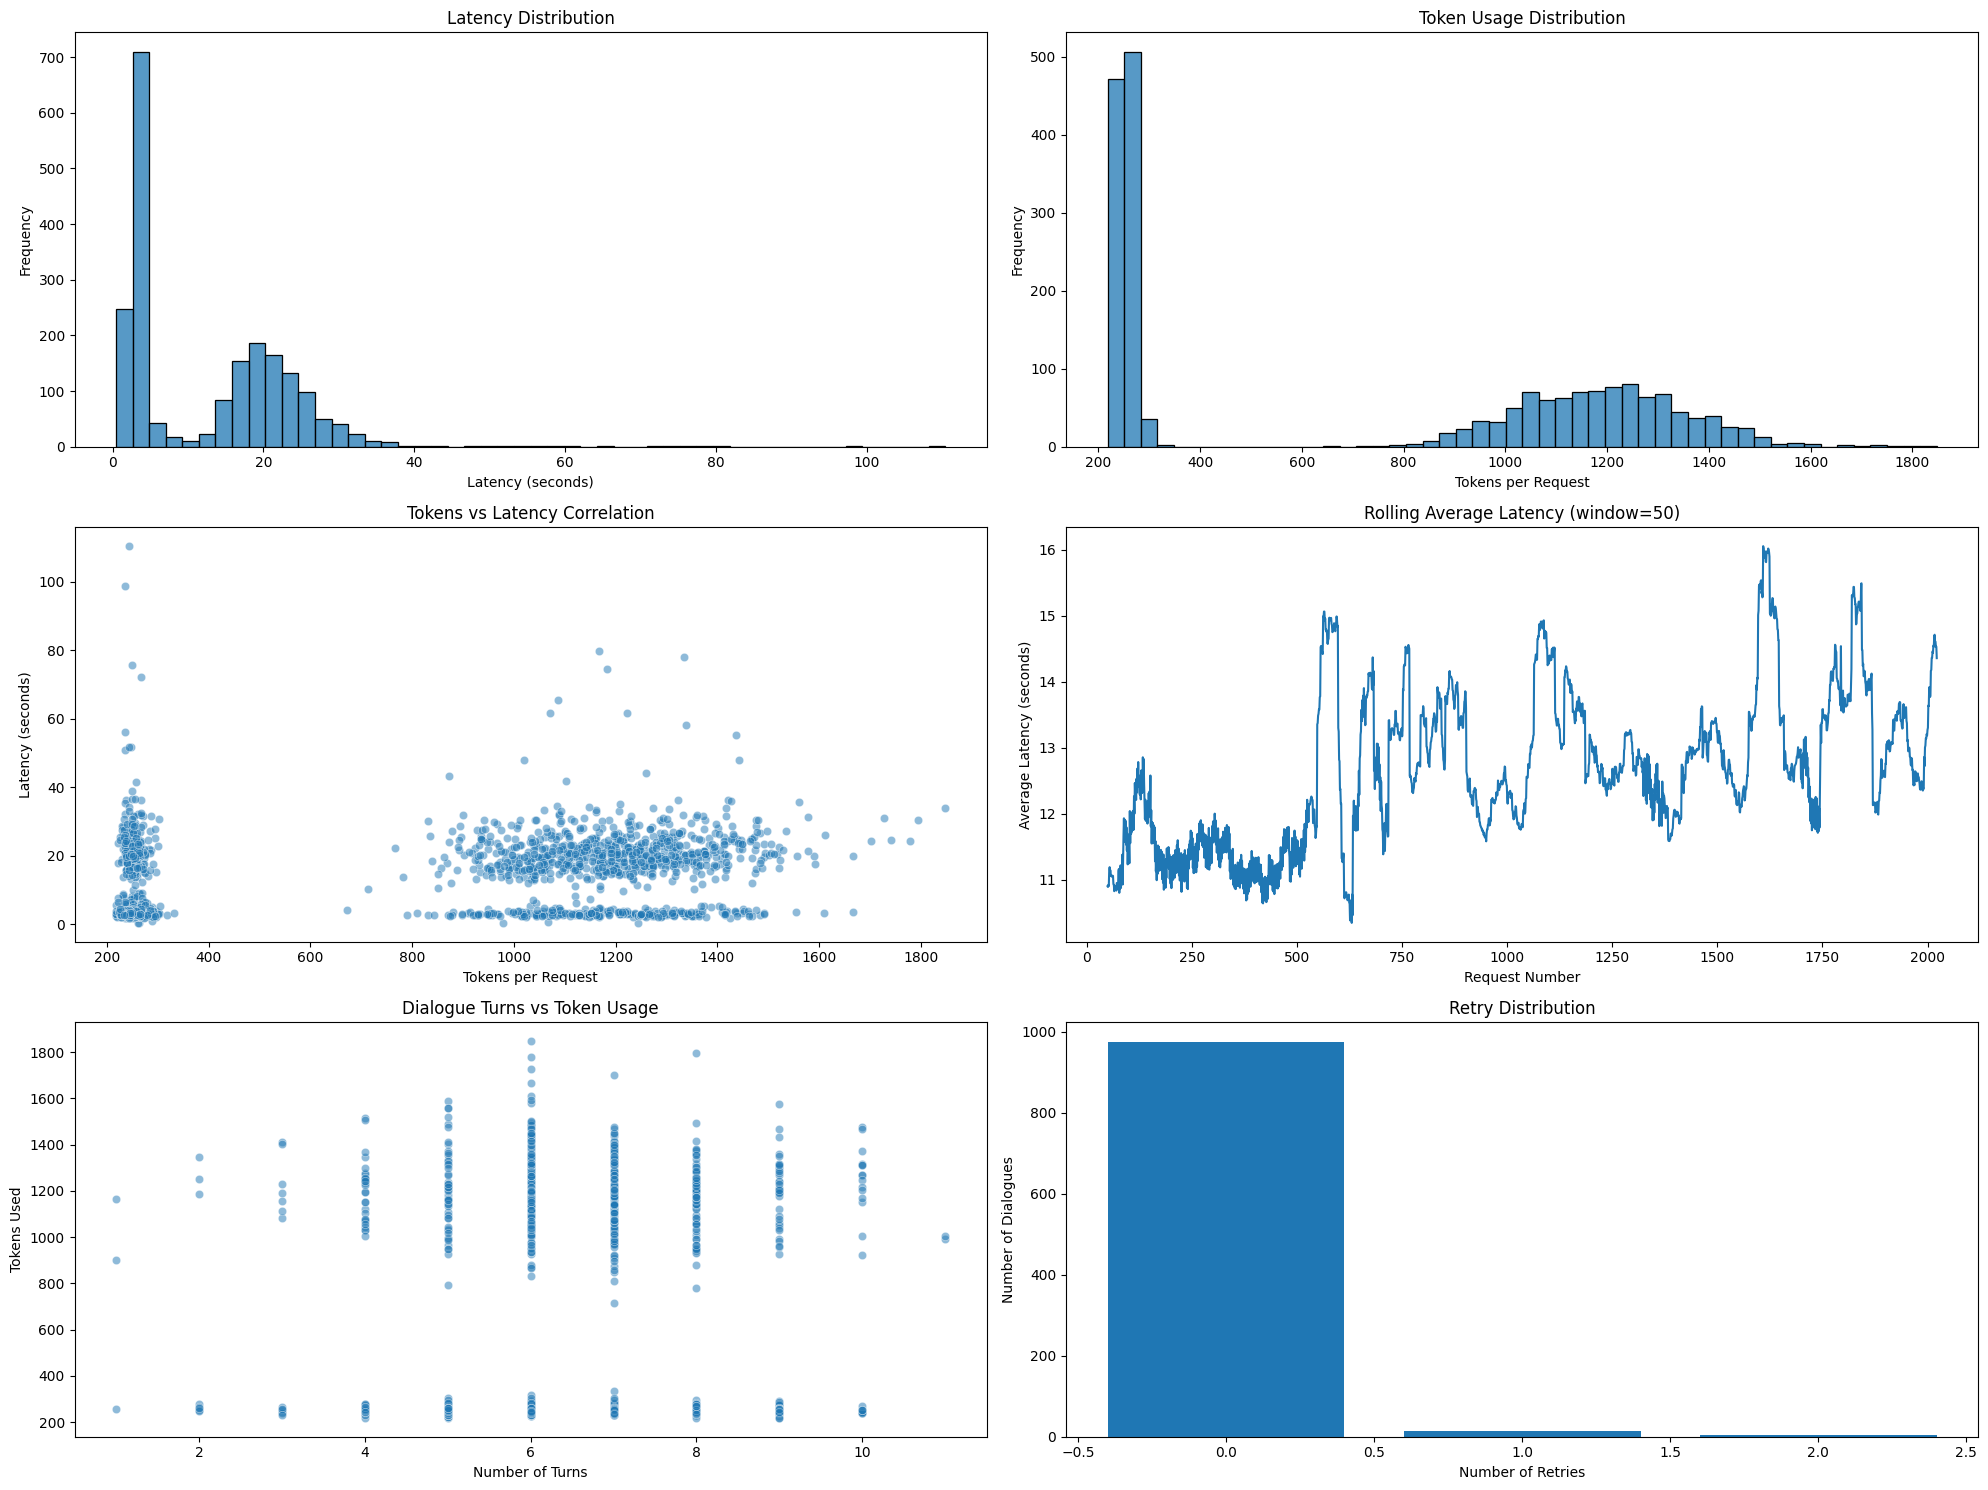


=== Additional Insights ===
Average tokens per successful dialogue: 718.8
Median dialogue length: 7.0 turns
Most common dialogue length: 6 turns

System throughput: 283.9 requests/hour
Overall token efficiency: 219.5 tokens per turn


In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from scipy import stats

def load_data() -> Tuple[Dict, pd.DataFrame]:
    """Load both JSON and CSV data"""
    with open('metrics.json', 'r') as f:
        json_data = json.load(f)
    
    csv_data = pd.read_csv('metrics.csv')
    return json_data, csv_data

def analyze_performance_patterns(df: pd.DataFrame) -> None:
    """Analyze performance patterns and anomalies"""
    # Identify potential performance anomalies
    latency_threshold = df['request_latencies'].mean() + 2 * df['request_latencies'].std()
    high_latency_requests = df[df['request_latencies'] > latency_threshold]
    
    print("\n=== Performance Patterns ===")
    print(f"Number of high-latency requests (>{latency_threshold:.2f}s): {len(high_latency_requests)}")
    print(f"Percentage of high-latency requests: {(len(high_latency_requests)/len(df))*100:.2f}%")
    
    # Analyze if high latency correlates with token usage
    high_latency_avg_tokens = high_latency_requests['tokens_used_per_request'].mean()
    normal_latency_avg_tokens = df[df['request_latencies'] <= latency_threshold]['tokens_used_per_request'].mean()
    print(f"Average tokens in high-latency requests: {high_latency_avg_tokens:.1f}")
    print(f"Average tokens in normal requests: {normal_latency_avg_tokens:.1f}")
    print(f"Token usage ratio (high/normal): {high_latency_avg_tokens/normal_latency_avg_tokens:.2f}x")

def analyze_token_efficiency(df: pd.DataFrame) -> None:
    """Analyze token usage patterns and efficiency"""
    print("\n=== Token Efficiency Analysis ===")
    
    # Calculate tokens per turn
    df['tokens_per_turn'] = df['tokens_used_per_request'] / df['dialogue_turns']
    
    print(f"Average tokens per turn: {df['tokens_per_turn'].mean():.1f}")
    print(f"Median tokens per turn: {df['tokens_per_turn'].median():.1f}")
    print(f"Most efficient dialogue (min tokens/turn): {df['tokens_per_turn'].min():.1f}")
    print(f"Least efficient dialogue (max tokens/turn): {df['tokens_per_turn'].max():.1f}")
    
    # Analyze relationship between turns and token usage
    correlation = df['dialogue_turns'].corr(df['tokens_used_per_request'])
    print(f"Correlation between turns and token usage: {correlation:.3f}")

def analyze_retry_patterns(json_data: Dict) -> None:
    """Analyze patterns in retry behavior"""
    retries = np.array(json_data['retries_per_dialogue'])
    total_dialogues = len(retries)
    
    print("\n=== Retry Pattern Analysis ===")
    retry_counts = np.bincount(retries.astype(int))
    for retries, count in enumerate(retry_counts):
        if count > 0:
            print(f"Dialogues with {retries} retries: {count} ({(count/total_dialogues)*100:.2f}%)")
    
    # Analyze retry clusters - using the recommended approach
    retry_positions = np.atleast_1d(retries > 0).nonzero()[0]
    if len(retry_positions) > 1:
        retry_gaps = np.diff(retry_positions)
        print(f"\nAverage gap between retry events: {retry_gaps.mean():.1f} dialogues")
        print(f"Longest gap between retries: {retry_gaps.max()} dialogues")


def analyze_latency_patterns(df: pd.DataFrame) -> None:
    """Detailed analysis of latency patterns"""
    print("\n=== Detailed Latency Analysis ===")
    
    # Time-based analysis (assuming sequential requests)
    df['request_number'] = range(len(df))
    df['rolling_mean_latency'] = df['request_latencies'].rolling(window=50).mean()
    
    # Latency stability
    latency_std = df['request_latencies'].std()
    latency_mean = df['request_latencies'].mean()
    latency_cv = latency_std / latency_mean  # Coefficient of variation
    
    print(f"Latency stability (CV): {latency_cv:.3f}")
    print(f"Latency standard deviation: {latency_std:.2f}s")
    
    # Analyze latency percentiles
    percentiles = [50, 75, 90, 95, 99]
    for p in percentiles:
        print(f"{p}th percentile latency: {df['request_latencies'].quantile(p/100):.2f}s")

def create_visualizations(df: pd.DataFrame, json_data: Dict) -> None:
    """Create comprehensive visualizations"""
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Latency Distribution
    plt.subplot(321)
    sns.histplot(data=df['request_latencies'], bins=50)
    plt.title('Latency Distribution')
    plt.xlabel('Latency (seconds)')
    plt.ylabel('Frequency')
    
    # 2. Token Usage Distribution
    plt.subplot(322)
    sns.histplot(data=df['tokens_used_per_request'], bins=50)
    plt.title('Token Usage Distribution')
    plt.xlabel('Tokens per Request')
    plt.ylabel('Frequency')
    
    # 3. Tokens vs Latency Scatter
    plt.subplot(323)
    sns.scatterplot(data=df, x='tokens_used_per_request', y='request_latencies', alpha=0.5)
    plt.title('Tokens vs Latency Correlation')
    plt.xlabel('Tokens per Request')
    plt.ylabel('Latency (seconds)')
    
    # 4. Rolling Average Latency
    plt.subplot(324)
    plt.plot(df['request_number'], df['rolling_mean_latency'])
    plt.title('Rolling Average Latency (window=50)')
    plt.xlabel('Request Number')
    plt.ylabel('Average Latency (seconds)')
    
    # 5. Turns vs Tokens
    plt.subplot(325)
    sns.scatterplot(data=df, x='dialogue_turns', y='tokens_used_per_request', alpha=0.5)
    plt.title('Dialogue Turns vs Token Usage')
    plt.xlabel('Number of Turns')
    plt.ylabel('Tokens Used')
    
    # 6. Retry Distribution
    plt.subplot(326)
    retry_counts = np.bincount(np.array(json_data['retries_per_dialogue']).astype(int))
    plt.bar(range(len(retry_counts)), retry_counts)
    plt.title('Retry Distribution')
    plt.xlabel('Number of Retries')
    plt.ylabel('Number of Dialogues')
    
    plt.tight_layout()
    plt.show()

def main():
    json_data, df = load_data()
    
    print("=== Basic Statistics ===")
    print(f"Total dialogues attempted: {json_data['total_dialogues_attempted']}")
    success_rate = (json_data['total_successful_dialogues'] / json_data['total_dialogues_attempted']) * 100
    print(f"Success rate: {success_rate:.2f}%")
    print(f"Total retries: {json_data['total_retries']}")
    
    # Run detailed analyses
    analyze_performance_patterns(df)
    analyze_token_efficiency(df)
    analyze_retry_patterns(json_data)
    analyze_latency_patterns(df)
    
    # Calculate and display correlations
    print("\n=== Correlation Matrix ===")
    correlations = df[['request_latencies', 'tokens_used_per_request', 
                      'dialogue_turns']].corr()
    print(correlations)
    
    # Create visualizations
    create_visualizations(df, json_data)
    
    # Additional insights
    print("\n=== Additional Insights ===")
    print(f"Average tokens per successful dialogue: {df['tokens_used_per_request'].mean():.1f}")
    print(f"Median dialogue length: {df['dialogue_turns'].median():.1f} turns")
    print(f"Most common dialogue length: {df['dialogue_turns'].mode().iloc[0]:.0f} turns")
    
    # Efficiency metrics
    throughput = len(df) / (df['request_latencies'].sum() / 3600)  # requests per hour
    print(f"\nSystem throughput: {throughput:.1f} requests/hour")
    
    # Token usage patterns
    token_efficiency = df['tokens_used_per_request'].sum() / df['dialogue_turns'].sum()
    print(f"Overall token efficiency: {token_efficiency:.1f} tokens per turn")

if __name__ == "__main__":
    main()

In [8]:
import pandas as pd
import numpy as np

# Read the CSV file with the correct column names and skip the header row
columns = ['retries_per_dialogue', 'request_latencies', 'tokens_used_per_request', 
           'dialogue_turns', 'total_dialogues_attempted', 'total_dialogues_generated', 
           'total_time_taken']

# Read CSV and skip the first row (header)
df = pd.read_csv('metrics.csv', names=columns, skiprows=1)

# Clean any potential string concatenation issues
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Calculate insights
insights = {
    'Average Latency': f"{df['request_latencies'].mean():.1f}s",
    'Latency Range': f"{df['request_latencies'].min():.1f}-{df['request_latencies'].max():.1f}s",
    'Typical Latency Range': f"{df['request_latencies'].quantile(0.25):.1f}-{df['request_latencies'].quantile(0.75):.1f}s",
    'Average Tokens per Request': f"{df['tokens_used_per_request'].mean():.1f}",
    'Median Tokens per Request': f"{df['tokens_used_per_request'].median():.1f}",
    'Average Dialogue Turns': f"{df['dialogue_turns'].mean():.1f}",
    'Retry Rate': f"{(df['retries_per_dialogue'] > 0).mean() * 100:.1f}%",
    'Token Range': f"{int(df['tokens_used_per_request'].min())}-{int(df['tokens_used_per_request'].max())}",
    'Short Dialogue Average': f"{df[df['dialogue_turns'] <= 5]['tokens_used_per_request'].mean():.1f} tokens",
    'Long Dialogue Average': f"{df[df['dialogue_turns'] > 5]['tokens_used_per_request'].mean():.1f} tokens"
}

# Create a DataFrame for nice display
results_df = pd.DataFrame.from_dict(insights, orient='index', columns=['Value'])
print("\nInsights Table:")
print(results_df)

# Additional statistics
print("\nAdditional Statistics:")
print(f"Dialogue Turns Distribution:\n{df['dialogue_turns'].value_counts().sort_index()}")
print(f"\nRetries Distribution:\n{df['retries_per_dialogue'].value_counts().sort_index()}")


Insights Table:
                                   Value
Average Latency                    12.1s
Latency Range                 0.5-110.4s
Typical Latency Range          2.9-19.9s
Average Tokens per Request         719.4
Median Tokens per Request          293.5
Average Dialogue Turns               6.6
Retry Rate                          1.9%
Token Range                     218-1848
Short Dialogue Average      689.1 tokens
Long Dialogue Average       727.1 tokens

Additional Statistics:
Dialogue Turns Distribution:
dialogue_turns
1.0       3
2.0       8
3.0      13
4.0      58
5.0     119
6.0     265
7.0     249
8.0     171
9.0      76
10.0     30
11.0      2
Name: count, dtype: int64

Retries Distribution:
retries_per_dialogue
0.0    975
1.0     14
2.0      5
Name: count, dtype: int64
